## Exploratory Data Analysis: Train JSONL

### 1.Imports & Configuration

In [1]:
import json
import os
import re
import sys
from pathlib import Path

import scienceplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlx_lm.tokenizer_utils import load as load_tokenizer

# ── project config ──────────────────────────────────────────────
sys.path.insert(0, str(Path.cwd().parent))  # ensure `src` is importable
from src.config import get_config

cfg = get_config()
plt.style.use(cfg.plotting.style)

### 2. Data Loading

In [2]:
data_path = cfg.train_jsonl_path
score_re  = cfg.score_regex

rows = []
with data_path.open("r", encoding="utf-8") as fh:
    for i, line in enumerate(fh):
        obj = json.loads(line)
        messages = obj.get("messages", [])

        user_text = ""
        assistant_text = ""
        for m in messages:
            role = m.get("role")
            if role == "user":
                user_text = m.get("content", "")
            elif role == "assistant":
                assistant_text = m.get("content", "")

        match = score_re.search(assistant_text)
        score = float(match.group(1)) if match else np.nan

        rows.append({
            "idx": i,
            "user_text": user_text,
            "assistant_text": assistant_text,
            "score": score,
            "user_chars": len(user_text),
            "assistant_chars": len(assistant_text),
            "total_chars": len(user_text) + len(assistant_text),
        })

df = pd.DataFrame(rows)
print(f"Total rows            : {len(df):,}")
print(f"Rows with parsed score: {df["score"].notna().sum():,}")
df.head(2)

Total rows            : 9,489
Rows with parsed score: 9,489


,idx,user_text,assistant_text,score,user_chars,assistant_chars,total_chars
0,0,User: pot grading scale in a table with grades...,"Score: 8.5/10. The response is helpful, harmle...",8.5,2772,61,2833
1,1,User: Create a pronunciation legend for all of...,"Score: 7.5/10. The response is helpful, harmle...",7.5,2860,61,2921


### 3. Tokenization

In [3]:
# ── resolve tokenizer path ───────────────────────────────────────
model_path = Path(cfg.tokenizer_path() or cfg.tokenizer.model_id)
print(f"Tokenizer: {model_path}")

tokenizer = load_tokenizer(model_path)


def token_len(text: str) -> int:
    """Return the number of tokens for *text* (without special tokens)."""
    try:
        return len(tokenizer.encode(text, add_special_tokens=False))
    except TypeError:
        return len(tokenizer.encode(text))


df["user_tokens"]      = df["user_text"].map(token_len)
df["assistant_tokens"] = df["assistant_text"].map(token_len)

# ── chat-level token count ────────────────────────────────────────
hf_tok = getattr(tokenizer, "_tokenizer", None)
has_chat_tpl = (
    hasattr(tokenizer, "apply_chat_template")
    and (
        getattr(tokenizer, "chat_template", None) is not None
        or getattr(hf_tok, "chat_template", None) is not None
    )
)

if has_chat_tpl:
    def _chat_tokens(row) -> int:
        msgs = [
            {"role": "user",      "content": row["user_text"]},
            {"role": "assistant", "content": row["assistant_text"]},
        ]
        try:
            ids = tokenizer.apply_chat_template(
                msgs, tokenize=True, add_generation_prompt=False
            )
            return len(ids)
        except Exception:
            return int(row["user_tokens"] + row["assistant_tokens"])
    df["chat_tokens"] = df.apply(_chat_tokens, axis=1)
else:
    print("No chat_template found; chat_tokens = user_tokens + assistant_tokens.")
    df["chat_tokens"] = df["user_tokens"] + df["assistant_tokens"]

df[["user_tokens", "assistant_tokens", "chat_tokens"]].describe()

Tokenizer: google/gemma-2-2b
No chat_template found; chat_tokens = user_tokens + assistant_tokens.


,user_tokens,assistant_tokens,chat_tokens
count,9489.000000,9489.000000,9489.000000
mean,636.787333,20.006112,656.793445
std,473.094525,0.077946,473.093247
min,53.000000,20.000000,73.000000
25%,319.000000,20.000000,339.000000
50%,527.000000,20.000000,547.000000
75%,816.000000,20.000000,836.000000
max,4551.000000,21.000000,4571.000000


### 4. Token Length Distribution

In [4]:
summary_cols = [
    "score", "user_chars", "assistant_chars", "total_chars",
    "user_tokens", "assistant_tokens", "chat_tokens",
]
display(df[summary_cols].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T)

print("\nScore distribution (count):")
display(df["score"].value_counts(dropna=False).sort_index())

,count,mean,std,min,50%,90%,95%,99%,max
score,9489.0,7.831278,1.118735,2.0,8.0,9.0,9.0,9.50,10.0
user_chars,9489.0,2735.055854,2032.813435,205.0,2273.0,5104.4,6413.4,10770.96,18776.0
assistant_chars,9489.0,61.006112,0.077946,61.0,61.0,61.0,61.0,61.00,62.0
total_chars,9489.0,2796.061966,2032.811889,266.0,2334.0,5165.4,6474.4,10831.96,18837.0
user_tokens,9489.0,636.787333,473.094525,53.0,527.0,1160.0,1499.0,2534.08,4551.0
assistant_tokens,9489.0,20.006112,0.077946,20.0,20.0,20.0,20.0,20.00,21.0
chat_tokens,9489.0,656.793445,473.093247,73.0,547.0,1180.0,1519.0,2554.08,4571.0



Score distribution (count):


score
2.0       31
3.0       85
4.0      128
4.5        5
5.0      111
5.5        6
6.0      441
6.5      172
7.0     1093
7.5     1214
8.0     2167
8.5     2834
9.0     1043
9.5      101
10.0      58
Name: count, dtype: int64

## 5. Token Length Distribution

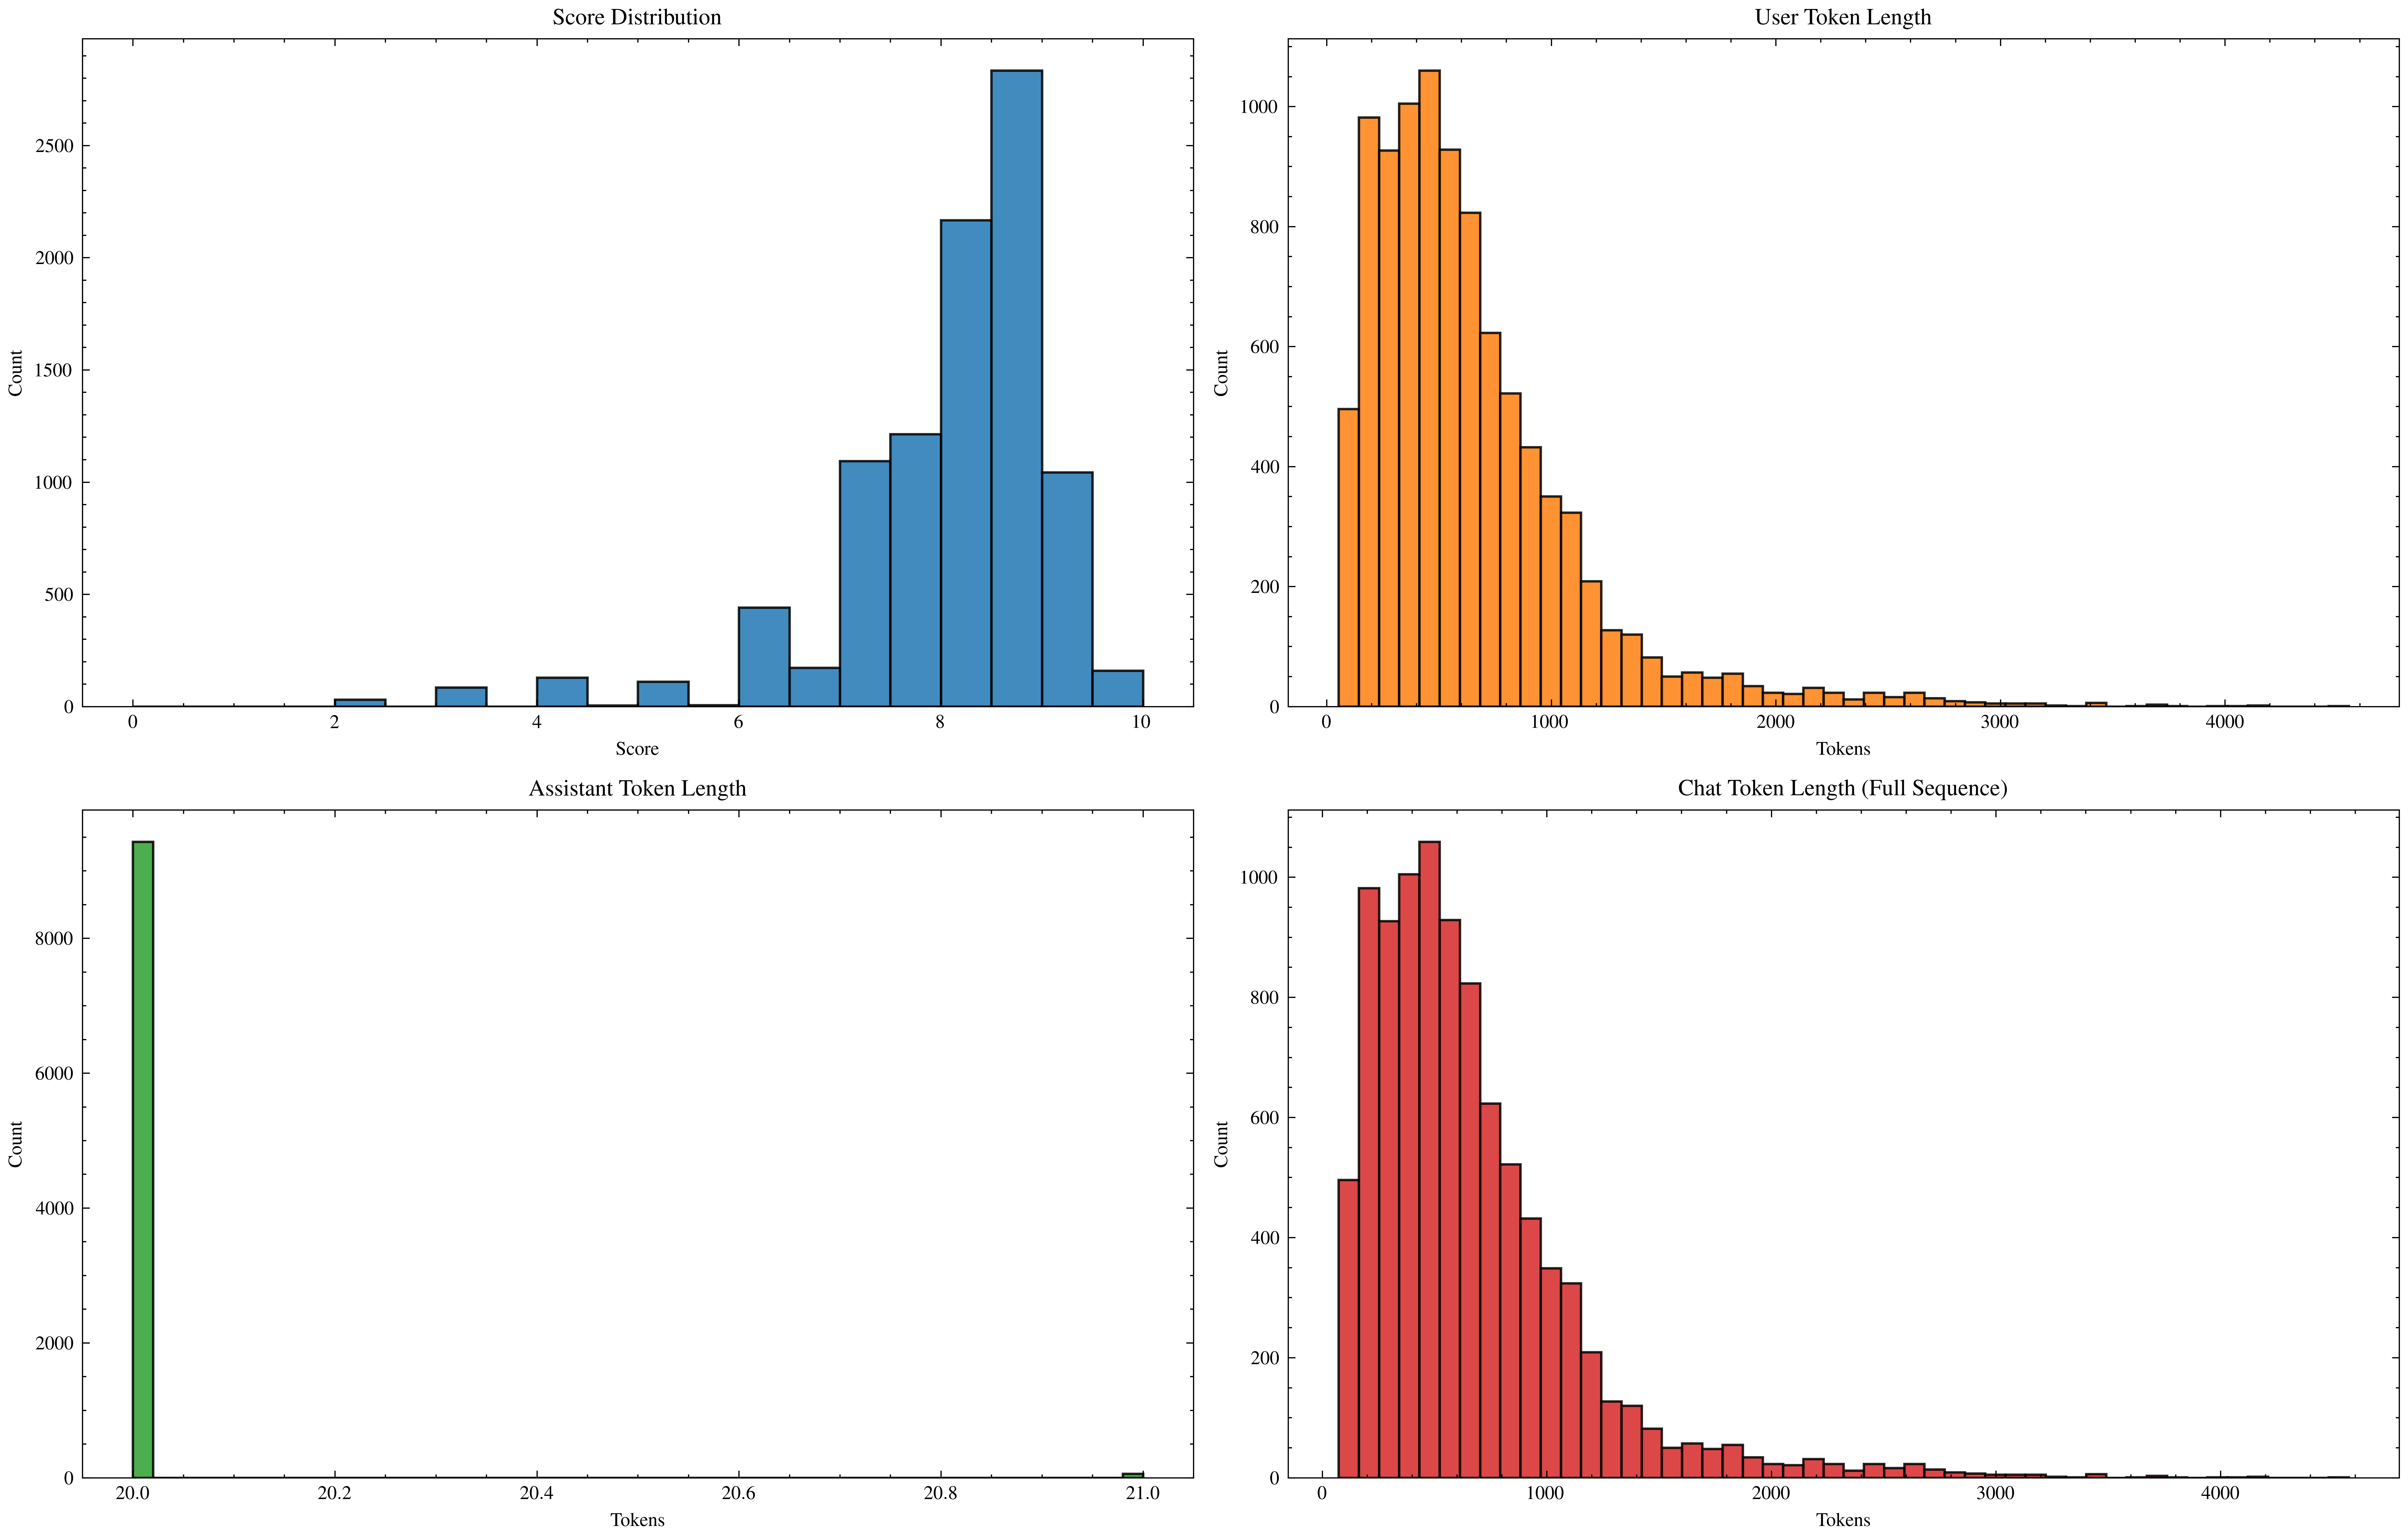

In [5]:
# ── Token-level distributions ─────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0, 0].hist(df["score"].dropna(), bins=np.arange(0, 10.5, 0.5),
                color="#1f77b4", edgecolor="black", alpha=0.85)
axes[0, 0].set_title("Score Distribution")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(df["user_tokens"], bins=50,
                color="#ff7f0e", edgecolor="black", alpha=0.85)
axes[0, 1].set_title("User Token Length")
axes[0, 1].set_xlabel("Tokens")
axes[0, 1].set_ylabel("Count")

axes[1, 0].hist(df["assistant_tokens"], bins=50,
                color="#2ca02c", edgecolor="black", alpha=0.85)
axes[1, 0].set_title("Assistant Token Length")
axes[1, 0].set_xlabel("Tokens")
axes[1, 0].set_ylabel("Count")

axes[1, 1].hist(df["chat_tokens"], bins=50,
                color="#d62728", edgecolor="black", alpha=0.85)
axes[1, 1].set_title("Chat Token Length (Full Sequence)")
axes[1, 1].set_xlabel("Tokens")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

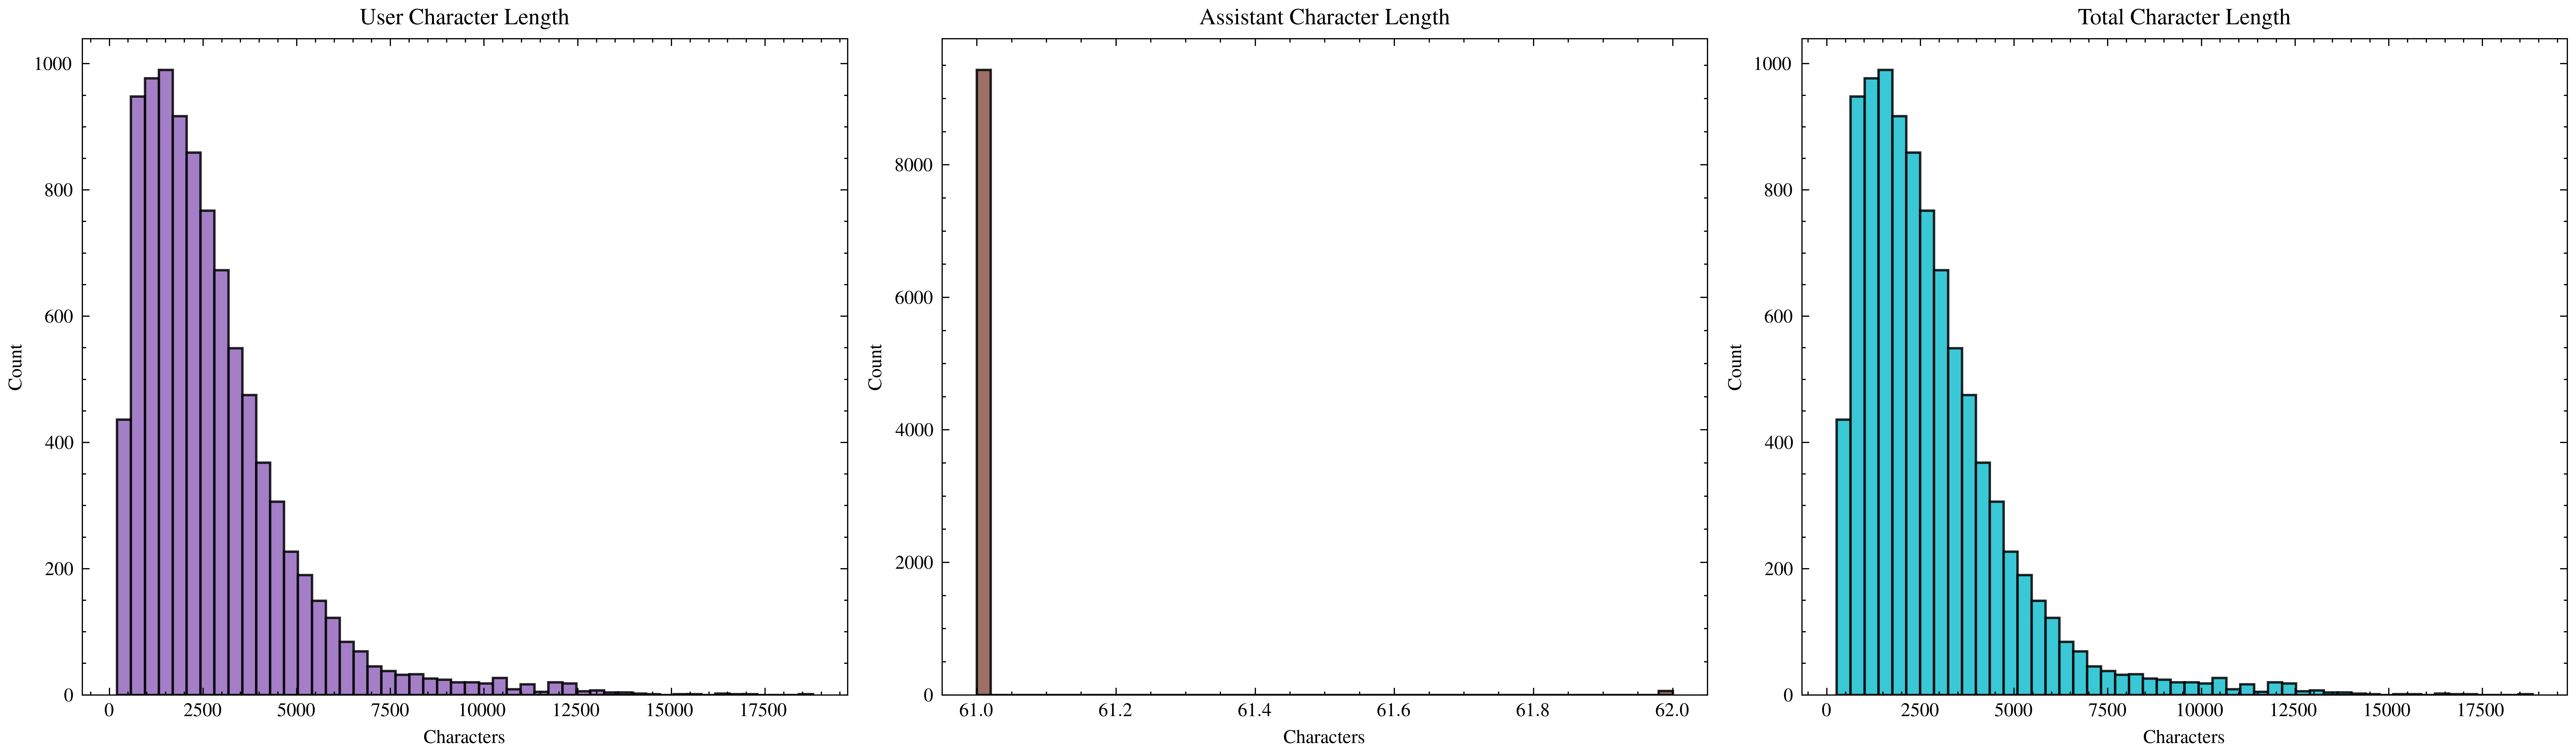

In [6]:
# ── Character-level distributions ────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

axes[0].hist(df["user_chars"], bins=50,
             color="#9467bd", edgecolor="black", alpha=0.85)
axes[0].set_title("User Character Length")
axes[0].set_xlabel("Characters")
axes[0].set_ylabel("Count")

axes[1].hist(df["assistant_chars"], bins=50,
             color="#8c564b", edgecolor="black", alpha=0.85)
axes[1].set_title("Assistant Character Length")
axes[1].set_xlabel("Characters")
axes[1].set_ylabel("Count")

axes[2].hist(df["total_chars"], bins=50,
             color="#17becf", edgecolor="black", alpha=0.85)
axes[2].set_title("Total Character Length")
axes[2].set_xlabel("Characters")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [7]:
# ── Longest sequences (by chat tokens) ───────────────────────────
display(df.nlargest(10, "chat_tokens")[["idx", "score", "user_tokens", "assistant_tokens", "chat_tokens"]])

,idx,score,user_tokens,assistant_tokens,chat_tokens
6101,6101,8.5,4551,20,4571
4342,4342,8.0,4183,20,4203
6576,6576,8.0,4120,20,4140
2337,2337,7.0,4027,20,4047
1635,1635,7.0,3980,20,4000
6833,6833,8.5,3803,20,3823
2253,2253,9.0,3674,20,3694
7284,7284,5.0,3666,20,3686
8785,8785,7.0,3665,20,3685
5296,5296,8.5,3603,20,3623
